# Hydrogeological balance

In [120]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import shapefile as shp
import os
#from mpl_toolkits.basemap import Basemap

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## NetCFD with month data

### Specify the file location

In [3]:
data = './temp-precip/era5-month-iceland.nc'
ds = nc.Dataset(data)

### Metadata

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-03-28 16:55:09 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/0aa2d2fd-096a-4108-a183-5c2c8361a713-adaptor.mars.internal-1680022509.0985382-1044-14-tmp.nc /cache/tmp/0aa2d2fd-096a-4108-a183-5c2c8361a713-adaptor.mars.internal-1680022449.285466-1044-12-tmp.grib
    dimensions(sizes): longitude(131), latitude(51), time(48)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 smlt(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [5]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-03-28 16:55:09 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/0aa2d2fd-096a-4108-a183-5c2c8361a713-adaptor.mars.internal-1680022509.0985382-1044-14-tmp.nc /cache/tmp/0aa2d2fd-096a-4108-a183-5c2c8361a713-adaptor.mars.internal-1680022449.285466-1044-12-tmp.grib'}


### Extracting the data

In [128]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:]) #mean per day
temp = np.array(ds['t2m'][:]) #mean per day
smlt = np.array(ds['smlt'][:]) #m of water equivalent
sf = np.array(ds['sf'][:])

### Converting the time

In [7]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
datime = []
for h in time :
    datime.append(origin + datetime.timedelta(hours = float(h)))

## Geographic data : watershed
Importing csv file with the centroïd of each watershed polygons. These polygons are the result of the intersection between the watershed of the gauging station and the era5 grid. 

In [139]:
surfdata = pd.read_csv("D:/MEMOIRE/SIG/djupa/watershed_v289_intersect.csv")

In [140]:
surfdata

,fid,DN,fid_2,cat,value,label,x_cent,y_cent,surface
0,915,-15871,2,1,1,NaN,-16.860,65.058,1.881037e+06
1,916,-15775,2,1,1,NaN,-16.792,65.071,1.993770e+07
2,917,-16048,2,1,1,NaN,-16.711,65.069,1.786373e+07
3,918,-16341,2,1,1,NaN,-16.601,65.056,6.040897e+06
4,919,-16620,2,1,1,NaN,-16.539,65.052,5.518144e+05
...,...,...,...,...,...,...,...,...,...
59,1442,14064,2,1,1,NaN,-17.196,64.514,3.719327e+07
60,1443,15464,2,1,1,NaN,-17.100,64.511,4.162775e+07
61,1444,16867,2,1,1,NaN,-17.002,64.515,3.770177e+07
62,1445,18118,2,1,1,NaN,-16.912,64.525,2.288154e+07


In [141]:
totsurf = np.sum(surfdata.surface)
print('Watershed area %0.1f m²' %totsurf)

Watershed area 2165459786.3 m²


### Map plotting

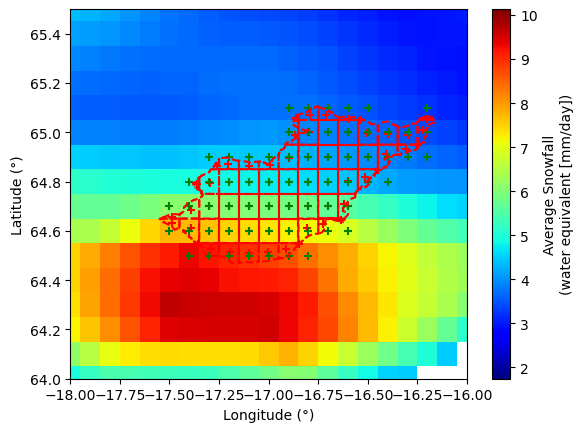

In [162]:
mapV = shp.Reader("D:/MEMOIRE/SIG/djupa/watershed_v289n_intersect.shp")

X, Y = np.meshgrid(LON, LAT)
sfmap = np.where(sf==-32767.,np.nan,sf) #converting into np.nan values
plt.figure()
plt.pcolormesh(X,Y,sfmap[24]*1000, cmap = 'jet')
plt.colorbar(label='Average Snowfall\n(water equivalent [mm/day])')

for shape in mapV.shapeRecords(): #djupa watershed
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, c='r',linestyle ='--')

for i in range(len(surfdata.y_cent)):
    idxLat = find_nearest(LAT, surfdata.y_cent[i])
    idxLong = find_nearest(LON, surfdata.x_cent[i])
    #print(LAT[idxLat],LON[idxLong])
    
    plt.scatter(surfdata.x_cent[i],surfdata.y_cent[i], marker='+', c='r')
    plt.scatter(LON[idxLong], LAT[idxLat], marker='+', c='green')
    
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.xlim(-18,-16)
plt.ylim(64.0,65.5)
plt.show()

### Computing the precipitation, ETR and snow melt with a surface ratio

In [143]:
dicth = {}
fid = list(surfdata.fid)
for idp in range(len(fid)) :
    lat = surfdata.y_cent[idp]
    lon = surfdata.x_cent[idp]
    idxLat = find_nearest(LAT, lat)
    idxLong = find_nearest(LON, lon)
    dsurf = surfdata.surface[idp]/totsurf
    #print(dsurf)
    P = []
    T = []
    SM = []
    SF = []
    for t in range(len(time)) :
        if t != len(time)-1 :
            dt = datime[t+1]-datime[t]
            dt = dt.days
        else :
            dt = 31
        P.append(float(prcp[t][idxLat][idxLong])*dsurf*dt*1000)
        T.append(float(temp[t][idxLat][idxLong])-273.15)
        SM.append(float(smlt[t][idxLat][idxLong])*dsurf*dt*1000)
        SF.append(float(sf[t][idxLat][idxLong])*dsurf*dt*1000)
    
    LP = np.array(P)-np.array(SF)
    L = 0.05*np.array(T)**3 + 25*np.array(T) + 300
    W = LP + np.array(SM)
    ETR = np.array(W)/(0.9+np.array(W)**2/L**2)**1/2
    print(len(P),len(T),len(SM),len(ETR),len(SF))
    R = np.block([T,P,list(ETR),list(LP),SF,SM])
    dicth.update({str(fid[idp]):R})
    #print(nantest)

48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48
48 48 48 48 48


### Sum the precipitation & Co.

In [144]:
tP = []
tETR = []
tLP = []
tSM = []
for a in dicth :
    tP.append(dicth[a][1])
    tETR.append(dicth[a][2])
    tLP.append(dicth[a][3])
    tSM.append(dicth[a][5])
sumP = np.sum(np.array(tP), axis = 0)
sumLP = np.sum(np.array(tLP), axis = 0)
sumETR = np.sum(np.array(tETR), axis = 0)
sumSM = np.sum(np.array(tSM), axis = 0)

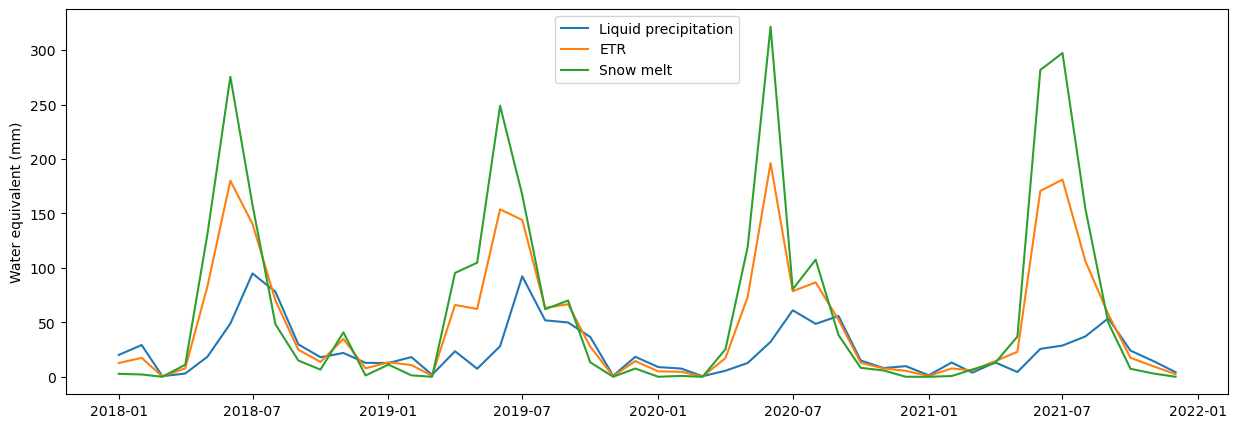

In [145]:
plt.figure(figsize=(15,5))
plt.plot(datime,sumLP, label='Liquid precipitation')
plt.plot(datime,sumETR, label='ETR')
plt.plot(datime,sumSM, label='Snow melt')
plt.ylabel('Water equivalent (mm)')
plt.legend()

## Analysis the water discharge

In [146]:
dhydro = pd.read_csv('D:/MEMOIRE/HYDRO/ALL-DVV/vdv_2018-2022-20230322092719-able-panda.csv',delimiter =';',low_memory=False) 

In [147]:
dich = {}

for a in dhydro :
    if a != 'Time' :
        pQ = np.array(dhydro[a])
        nantest = np.array(pd.notna(pQ))
        Q = np.extract(nantest,pQ).astype(str)
        Q = np.char.replace(Q,',','.').astype(object)
        T = np.extract(nantest,dhydro['Time']).astype(object)
        R = np.block([[T], [Q]])
        dich.update({a: R})
    #print(nantest)

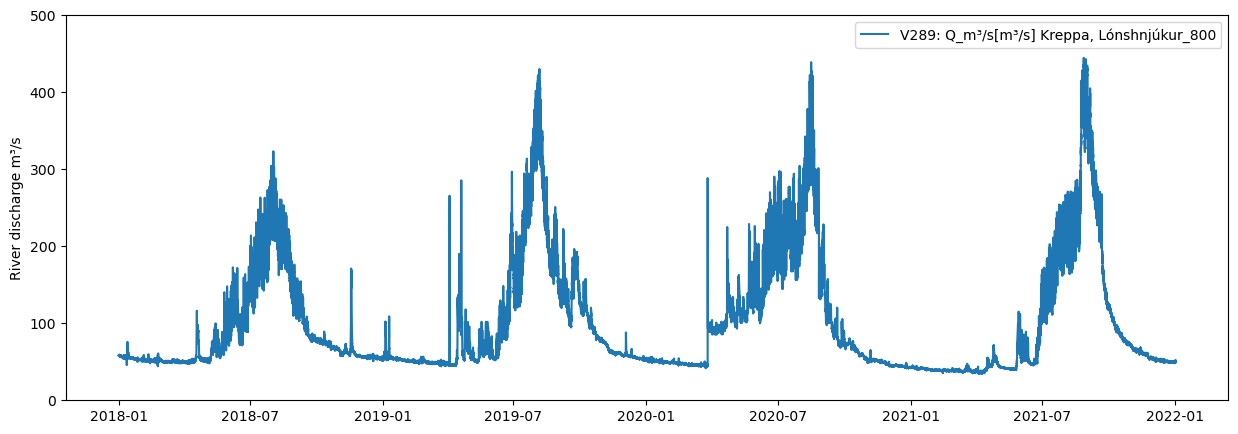

In [148]:
plt.figure(figsize=(15,5))
line = 1
for a in dich :
    if len(dich[a][0]) > 10 and line == 3:
        plt.plot(dich[a][0].astype(np.datetime64),dich[a][1].astype('float64'), label=a)
        plt.ylim(0,500)
    line += 1
plt.ylabel('River discharge m³/s')
plt.legend()
plt.show()

### Sum the discharge on the watershed area

In [149]:
disT = dich['V289: Q_m³/s[m³/s] Kreppa, Lónshnjúkur_800'][0]
disQ = dich['V289: Q_m³/s[m³/s] Kreppa, Lónshnjúkur_800'][1]

In [150]:
sQ = 0
t0 = datetime.datetime.strptime(disT[0], '%Y-%m-%d %H:%M:%S')
sumQ = []
for it in enumerate(disT) :
    tn = datetime.datetime.strptime(disT[it[0]], '%Y-%m-%d %H:%M:%S')
    if it[0] < len(disT) - 1 :
        t1 = datetime.datetime.strptime(disT[it[0]+1], '%Y-%m-%d %H:%M:%S') 
        dt = t1 - tn
    sQ += float(disQ[it[0]])*dt.seconds
    if tn.day == 1 and tn.hour == 0 and tn.minute == 0 and it[0]!=0 :
        #print(tn)
        sumQ.append(sQ)
        sQ = 0

In [151]:
sumQmm = np.array(sumQ)*1000/totsurf

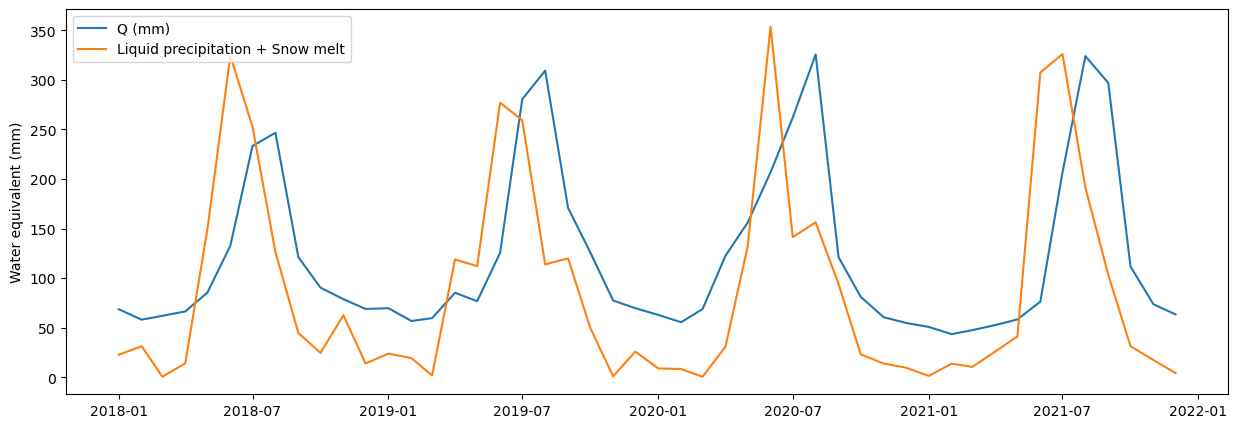

In [152]:
plt.figure(figsize=(15,5))
plt.plot(datime,sumQmm, label='Q (mm)')
plt.plot(datime,sumLP + sumSM, label='Liquid precipitation + Snow melt')
plt.ylabel('Water equivalent (mm)')
plt.legend()

### Water balance
### P + SM = Q + ETR + dR => dR = P + SM - Q - ETR

In [153]:
dR = sumLP+sumSM-sumQmm-ETR #+ 30#terme de fermeture

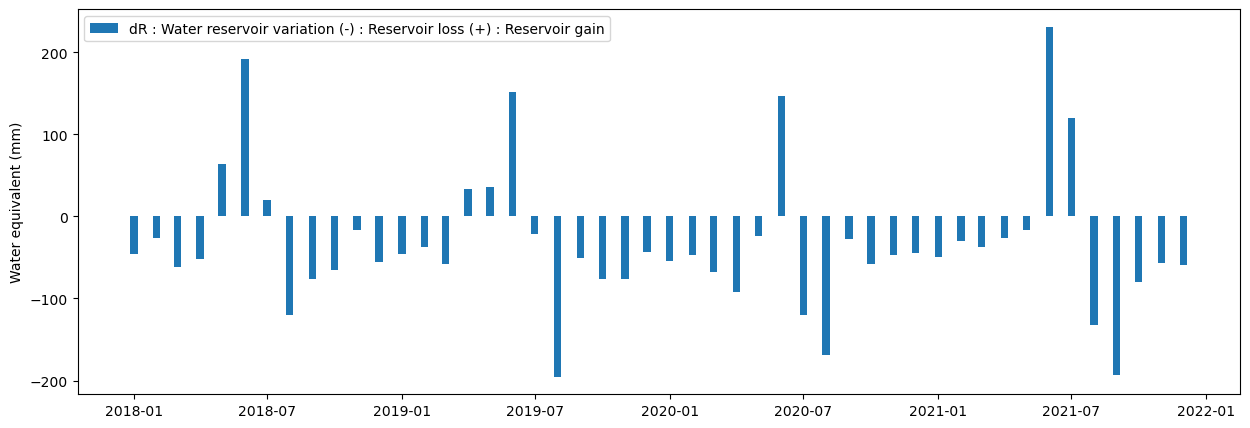

In [154]:
plt.figure(figsize=(15,5))
plt.bar(datime,dR, label='dR : Water reservoir variation (-) : Reservoir loss (+) : Reservoir gain', width=10)
plt.ylabel('Water equivalent (mm)')
plt.legend()

In [155]:
vR = []
R = 0
for elem in dR :
    R+=elem
    vR.append(R)

## Comparing dv/v and dR

In [156]:
component = 'ZZ'
mwlength = '015'
filterID = '07'

# Root of the dtt files to plot
root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
folder = os.listdir(root)
# Root of the stations pairs names
rootpair = 'D:/MEMOIRE/MSNoise/ablation/MWCS/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
pair_name = os.listdir(rootpair)

In [157]:
df = pd.read_csv(root+folder[0])

In [158]:
df

,Date,Pairs,M,EM,A,EA,M0,EM0
0,2018-01-01,VI_BJK_VI_DJK,-0.002168,0.002124,0.089439,0.035664,0.002979,0.000787
1,2018-01-01,VI_BJK_VI_GRF,0.000913,0.000784,-0.032678,0.010033,0.000785,0.001205
2,2018-01-01,VI_BJK_VI_URH,0.000157,0.000833,0.060827,0.015363,0.001922,0.001707
3,2018-01-01,VI_DJK_VI_GRF,0.001233,0.000531,-0.049094,0.009756,0.001890,0.001369
4,2018-01-01,VI_GRF_VI_URH,0.000950,0.001384,0.016298,0.022445,0.001055,0.001310
5,2018-01-01,ALL,0.000938,0.000919,-0.021149,0.018174,0.000488,0.000849


In [159]:
dvvTime = []
dvvM = []
for file in folder :
    find = root+file
    df = pd.read_csv(find)
    idx = list(df['Pairs']).index('ALL')
    dvvTime.append(datetime.datetime.strptime(df['Date'][idx],'%Y-%m-%d'))
    dvvM.append(df['M'][idx]*100)

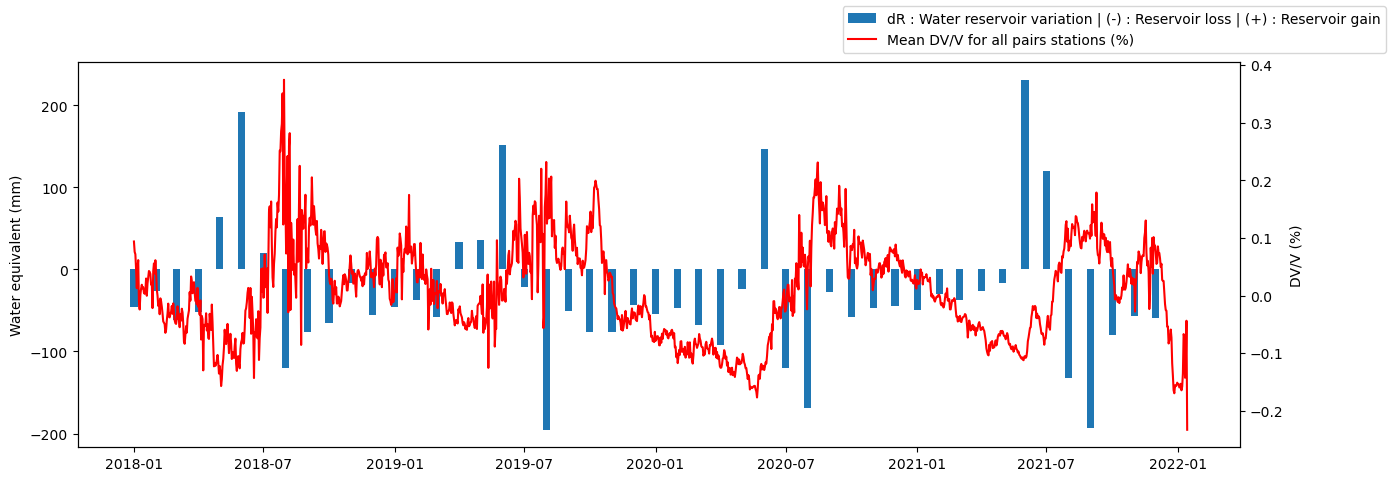

In [160]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_ylabel('Water equivalent (mm)')
ax1.bar(datime,dR, label='dR : Water reservoir variation | (-) : Reservoir loss | (+) : Reservoir gain', width=10)
#ax1.plot(datime,vR, label='dR : Water reservoir variation (-) : Reservoir loss (+) : Reservoir gain')  

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('DV/V (%)') 
ax2.plot(dvvTime, dvvM, label='Mean DV/V for all pairs stations (%)', c='r')
 
# Show plot
fig.legend()
plt.show()